In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('NIFTY 50_minute.csv')

In [3]:
df.shape

(909321, 6)

In [4]:
df.head()

,date,open,high,low,close,volume
0,2015-01-09 09:15:00,8285.45,8295.90,8285.45,8292.10,0
1,2015-01-09 09:16:00,8292.60,8293.60,8287.20,8288.15,0
2,2015-01-09 09:17:00,8287.40,8293.90,8287.40,8293.90,0
3,2015-01-09 09:18:00,8294.25,8300.65,8293.90,8300.65,0
4,2015-01-09 09:19:00,8300.60,8301.30,8298.75,8301.20,0


In [5]:
df.tail()

,date,open,high,low,close,volume
909316,2024-11-08 15:25:00,24135.00,24135.80,24125.95,24126.70,0
909317,2024-11-08 15:26:00,24126.50,24126.80,24114.35,24116.80,0
909318,2024-11-08 15:27:00,24119.15,24122.10,24113.45,24116.70,0
909319,2024-11-08 15:28:00,24114.40,24116.45,24107.35,24110.10,0
909320,2024-11-08 15:29:00,24108.75,24115.55,24104.70,24110.35,0


#### Seperating date column into (YYYY-MM-DD) and time (HH:MM)

In [6]:
df['time'] = df['date'].apply(lambda x: x[11:-3])
df['date'] = df['date'].apply(lambda x: x[:10])
df.head()

,date,open,high,low,close,volume,time
0,2015-01-09,8285.45,8295.90,8285.45,8292.10,0,09:15
1,2015-01-09,8292.60,8293.60,8287.20,8288.15,0,09:16
2,2015-01-09,8287.40,8293.90,8287.40,8293.90,0,09:17
3,2015-01-09,8294.25,8300.65,8293.90,8300.65,0,09:18
4,2015-01-09,8300.60,8301.30,8298.75,8301.20,0,09:19


In [7]:
time_counts = df['time'].value_counts()
print(time_counts)

time
09:55    2426
11:54    2426
09:54    2426
09:56    2426
09:48    2426
         ... 
17:56       2
17:57       2
17:42       1
17:43       1
17:44       1
Name: count, Length: 495, dtype: int64


In [8]:
extra_time = df[df['time'] >= '17:30']
print(extra_time['date'].unique())

['2015-11-11' '2016-10-30' '2017-10-19' '2018-11-07' '2019-10-27'
 '2020-11-14' '2021-11-04' '2022-10-24' '2023-11-12' '2024-11-01']


#### The above given dates correspond to Diwali. So in light of this festival, the market operates in the evening.

In [9]:
df['previous_close'] = df['close'].shift(1)
df['tr'] = df.apply(lambda row: max(row['high'] - row['low'], abs(row['high'] - row['previous_close']), abs(row['low'] - row['previous_close'])), axis=1)
df.drop(columns=['previous_close'], inplace=True)

In [10]:
df.head()

,date,open,high,low,close,volume,time,tr
0,2015-01-09,8285.45,8295.90,8285.45,8292.10,0,09:15,10.45
1,2015-01-09,8292.60,8293.60,8287.20,8288.15,0,09:16,6.40
2,2015-01-09,8287.40,8293.90,8287.40,8293.90,0,09:17,6.50
3,2015-01-09,8294.25,8300.65,8293.90,8300.65,0,09:18,6.75
4,2015-01-09,8300.60,8301.30,8298.75,8301.20,0,09:19,2.55


#### Using the true range for each interval, we will group these and find the median for the average volatility observed during this time of the day. 
#### We take median as the average measure as mean can be affected by higher outliers

In [11]:
intraday_atr = df.groupby('time')['tr'].median()
intraday_atr_df = intraday_atr.reset_index()
intraday_atr_df.columns = ['time', 'tr']

In [12]:
intraday_atr_df.head()

,time,tr
0,09:15,49.475
1,09:16,10.900
2,09:17,9.300
3,09:18,8.575
4,09:19,8.125


In [13]:
print(intraday_atr_df['time'].values[374])

15:29


#### Now we plot the median TR values for the times 9:16 - 15:29

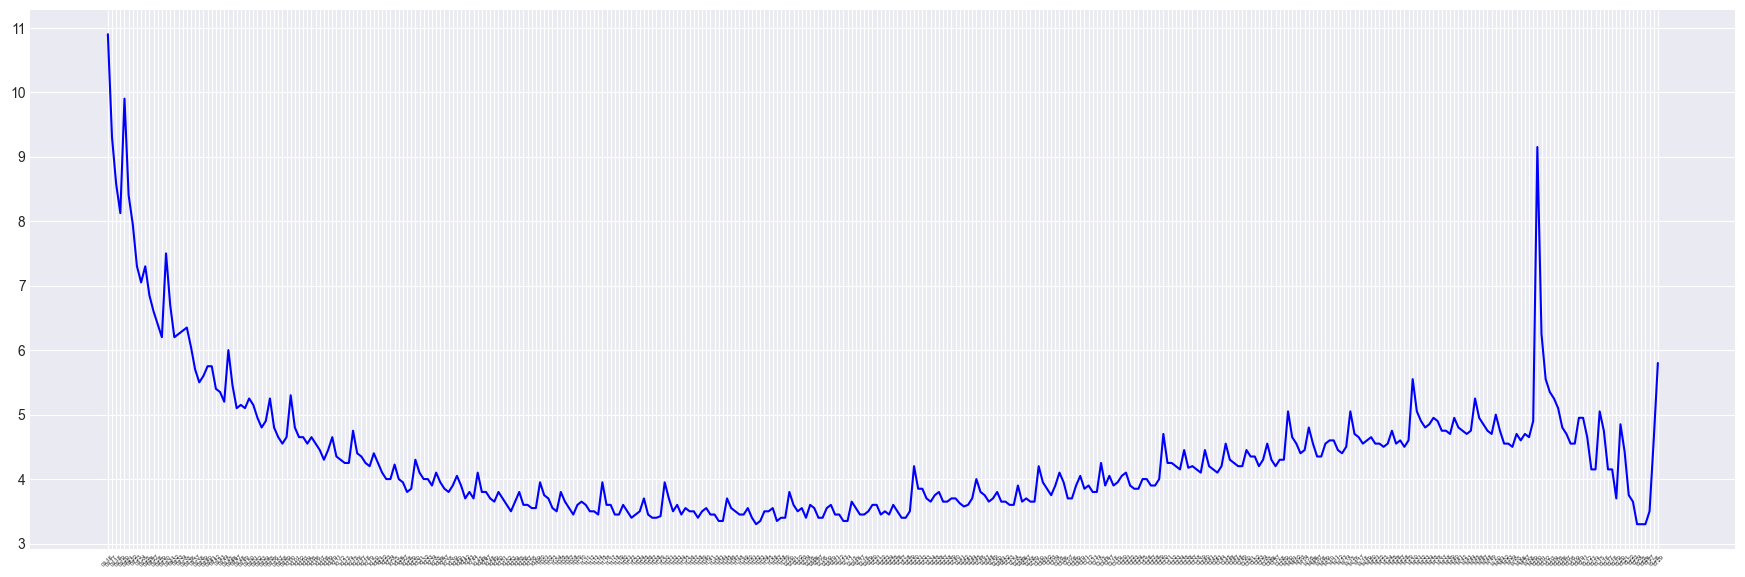

In [14]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(22, 7))
plt.plot(intraday_atr_df['time'].values[1:375], intraday_atr_df['tr'].values[1:375], color='blue') # Excluding the first value since it is an outlier as it uses the previous day's close price
plt.xticks(rotation=45, fontsize = 4)
plt.show()

#### So we observe that in the middle of the day, the volatility is low. At the starting hours and towards the ending hours, we observe relatively higher volatility.

In [15]:
df.head()

,date,open,high,low,close,volume,time,tr
0,2015-01-09,8285.45,8295.90,8285.45,8292.10,0,09:15,10.45
1,2015-01-09,8292.60,8293.60,8287.20,8288.15,0,09:16,6.40
2,2015-01-09,8287.40,8293.90,8287.40,8293.90,0,09:17,6.50
3,2015-01-09,8294.25,8300.65,8293.90,8300.65,0,09:18,6.75
4,2015-01-09,8300.60,8301.30,8298.75,8301.20,0,09:19,2.55


#### Aggregating minute OHLC data to daily OHLC data

In [16]:
# Convert 'date' and 'time' columns to datetime
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.set_index('datetime', inplace=True)

# Resample to daily data
daily_df = df.resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

daily_df.reset_index(inplace=True)

In [17]:
daily_df['previous_close'] = daily_df['close'].shift(1)
daily_df['tr'] = daily_df.apply(lambda row: max(row['high'] - row['low'], abs(row['high'] - row['previous_close']), abs(row['low'] - row['previous_close'])), axis=1)
daily_df.drop(columns=['previous_close'], inplace=True)

In [18]:
daily_df.head()

,datetime,open,high,low,close,volume,tr
0,2015-01-09,8285.45,8303.00,8191.10,8280.25,0,111.90
1,2015-01-12,8291.35,8332.25,8245.60,8326.55,0,86.65
2,2015-01-13,8346.15,8356.65,8268.15,8303.80,0,88.50
3,2015-01-14,8307.25,8326.30,8236.75,8287.75,0,89.55
4,2015-01-15,8425.20,8526.90,8380.75,8461.15,0,239.15


In [19]:
df.reset_index(inplace=True)
df.head()

,datetime,date,open,high,low,close,volume,time,tr
0,2015-01-09 09:15:00,2015-01-09,8285.45,8295.90,8285.45,8292.10,0,09:15,10.45
1,2015-01-09 09:16:00,2015-01-09,8292.60,8293.60,8287.20,8288.15,0,09:16,6.40
2,2015-01-09 09:17:00,2015-01-09,8287.40,8293.90,8287.40,8293.90,0,09:17,6.50
3,2015-01-09 09:18:00,2015-01-09,8294.25,8300.65,8293.90,8300.65,0,09:18,6.75
4,2015-01-09 09:19:00,2015-01-09,8300.60,8301.30,8298.75,8301.20,0,09:19,2.55


In [20]:
class TemporalVolatilityAnalyzer:
    def __init__(self, df):
        self.df = df.copy()
        self.df.set_index('datetime', inplace=True)
        self.df['month'] = self.df.index.month
        self.df['year'] = self.df.index.year
        self.df['weekday'] = self.df.index.weekday
        
    def plot_monthly_volatility(self):
        monthly_vol = self.df.groupby(['year', 'month'])['tr'].median().reset_index()
        monthly_vol['date'] = pd.to_datetime(monthly_vol[['year', 'month']].assign(DAY=1))
        
        plt.figure(figsize=(14, 7))
        plt.plot(monthly_vol['date'], monthly_vol['tr'])
        plt.title('Average Monthly Volatility')
        plt.xlabel('Date')
        plt.ylabel('Average Volatility')
        plt.grid(True)
        plt.show()
        
    def analyze_weekday_patterns(self):
        business_days_df = self.df[self.df['weekday'].between(0, 4)] # Taking only weekdays
        weekday_stats = business_days_df.groupby('weekday')['tr'].agg(['median', 'mean', 'std', 'count']).round(2)
        weekday_stats.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        return weekday_stats

#### From the statistics below, we find that Monday on average has relatively the highest volatility. This could be because the market opens for the week on Monday.

In [21]:
temp_analyzer = TemporalVolatilityAnalyzer(daily_df)
weekday_stats = temp_analyzer.analyze_weekday_patterns()
print("\nWeekday Volatility Statistics:")
print(weekday_stats)


Weekday Volatility Statistics:
           median    mean     std  count
Monday     140.18  174.86  129.23    482
Tuesday    129.00  154.39  126.80    485
Wednesday  129.27  151.49   97.71    492
Thursday   130.80  156.74  105.79    489
Friday     129.75  163.67  126.48    479


#### The plot of monthly volatility shows that the onset of COVID-19 caused the highest volatility observed over the given period

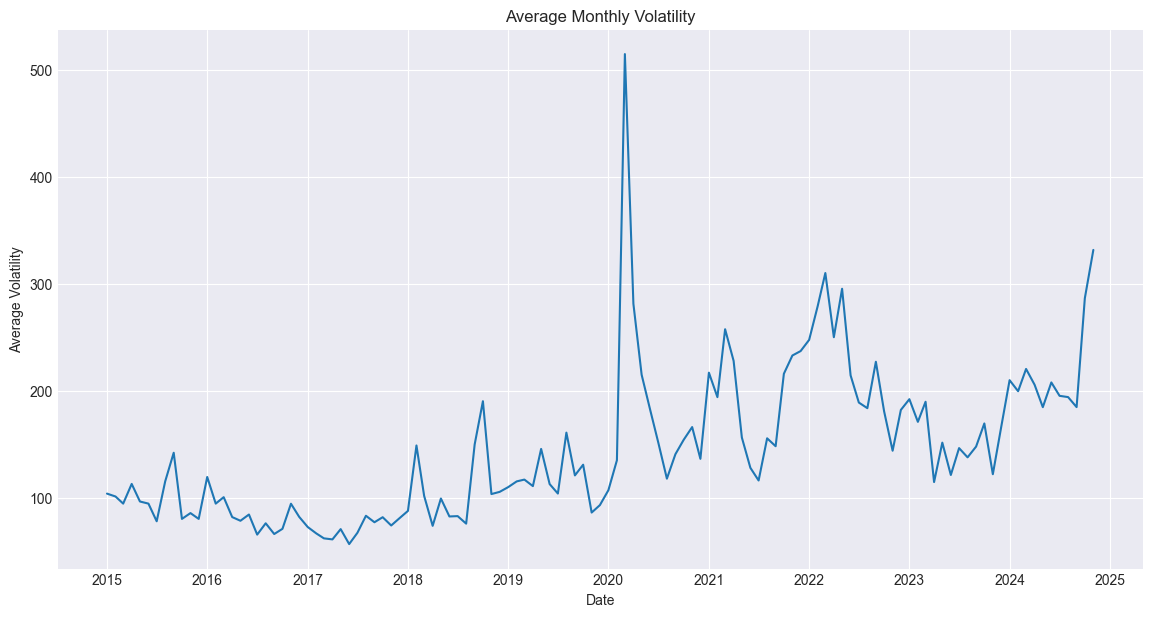

In [22]:
temp_analyzer.plot_monthly_volatility()

### Approach 1: Detecting surges in volatility using deflection from mean ATR
- We compare this ATR with the mean ATR from the last 14 days
- If ATR > mean of ATR + 2 * (std of ATR), then it indicates a surge in volatility
- We also merge periods if they are close to each other

In [23]:
class VolatilitySurgeAnalyzer:
    def __init__(self, data):
        self.data = data.copy()
        self.data.set_index('datetime', inplace=True)
        
    def calculate_atr(self, window):
        self.data['atr'] = self.data['tr'].rolling(window).mean()
        self.data['atr_mean'] = self.data['atr'].rolling(window).mean()
        self.data['atr_std'] = self.data['atr'].rolling(window).std()
    
    def identify_volatility_surges(self, window, std_threshold, min_duration, merge_gap):
        self.calculate_atr(window)
        atr = self.data['atr']
        atr_mean = self.data['atr_mean']
        atr_std = self.data['atr_std']
        
        surge_points = atr > (atr_mean + std_threshold * atr_std)
        
        surge_periods = []
        start_idx = None
        
        for i in range(len(surge_points)):
            if surge_points.iloc[i] and start_idx is None:
                start_idx = i
            elif not surge_points.iloc[i] and start_idx is not None:
                if i - start_idx >= min_duration:
                    surge_periods.append({
                        'start_date': atr.index[start_idx].strftime('%Y-%m-%d'),
                        'end_date': atr.index[i-1].strftime('%Y-%m-%d'),
                        'duration': i - start_idx,
                    })
                start_idx = None
        
        if len(surge_periods) == 0: return pd.DataFrame()
        
        merged_periods = []
        current_period = surge_periods[0]
        
        for i in range(1, len(surge_periods)):
            days_between = (pd.to_datetime(surge_periods[i]['start_date']) - pd.to_datetime(current_period['end_date'])).days - 1
            
            if days_between <= merge_gap:
                current_period['end_date'] = surge_periods[i]['end_date']
                current_period['duration'] += surge_periods[i]['duration'] + days_between
            else:
                merged_periods.append(current_period)
                current_period = surge_periods[i]
        
        merged_periods.append(current_period)
        surge_df = pd.DataFrame(merged_periods)
        
        return surge_df
    
    def plot_volatility_analysis(self, window, std_threshold, min_duration, merge_gap):
        surge_df = self.identify_volatility_surges(window, std_threshold, min_duration, merge_gap)
        atr = self.data['atr']
        atr_mean = self.data['atr_mean']
        atr_std = self.data['atr_std']
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), height_ratios=[2, 1])
        fig.suptitle('Volatility Surge Analysis', fontsize=14)
        
        ax1.plot(self.data.index, self.data['close'], color='blue', alpha=0.6, label='Close Price')
        
        for _, surge in surge_df.iterrows():
            start = pd.to_datetime(surge['start_date'])
            end = pd.to_datetime(surge['end_date'])
            ax1.axvspan(start, end, color='red', alpha=0.2)
        
        ax1.set_title('Price Chart with Volatility Surge Periods')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price')
        ax1.legend()
        
        ax2.plot(atr.index, atr, label='ATR', color='blue')
        ax2.plot(atr_mean.index, atr_mean, label='ATR Mean', color='green', linestyle='--')
        ax2.plot(atr_mean.index, atr_mean + std_threshold * atr_std, label=f'Threshold ({std_threshold}σ)', color='red', linestyle=':')
        
        for _, surge in surge_df.iterrows():
            start = pd.to_datetime(surge['start_date'])
            end = pd.to_datetime(surge['end_date'])
            ax2.axvspan(start, end, color='red', alpha=0.2)
        
        ax2.set_title('ATR and Volatility Thresholds')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('ATR')
        ax2.legend()

        fig.tight_layout()
        return fig
    
    def get_surge_summary(self, surge_df):
        if len(surge_df) == 0:
            return "No significant volatility surges detected."
            
        summary = "Volatility Surge Periods:\n\n"
        
        for i, surge in surge_df.iterrows():
            summary += f"Period {i+1}:"
            summary += f"- Duration: {surge['start_date']} to {surge['end_date']} "
            summary += f"({surge['duration']} days)\n"
        
        return summary

Volatility Surge Periods:

Period 1:- Duration: 2015-08-18 to 2015-08-26 (7 days)
Period 2:- Duration: 2016-01-14 to 2016-01-20 (5 days)
Period 3:- Duration: 2016-11-09 to 2016-11-15 (4 days)
Period 4:- Duration: 2017-12-13 to 2017-12-19 (5 days)
Period 5:- Duration: 2018-02-01 to 2018-02-06 (4 days)
Period 6:- Duration: 2018-09-03 to 2018-09-06 (4 days)
Period 7:- Duration: 2020-02-01 to 2020-02-05 (4 days)
Period 8:- Duration: 2022-12-21 to 2022-12-26 (4 days)
Period 9:- Duration: 2024-07-23 to 2024-07-29 (5 days)
Period 10:- Duration: 2024-10-04 to 2024-10-09 (4 days)



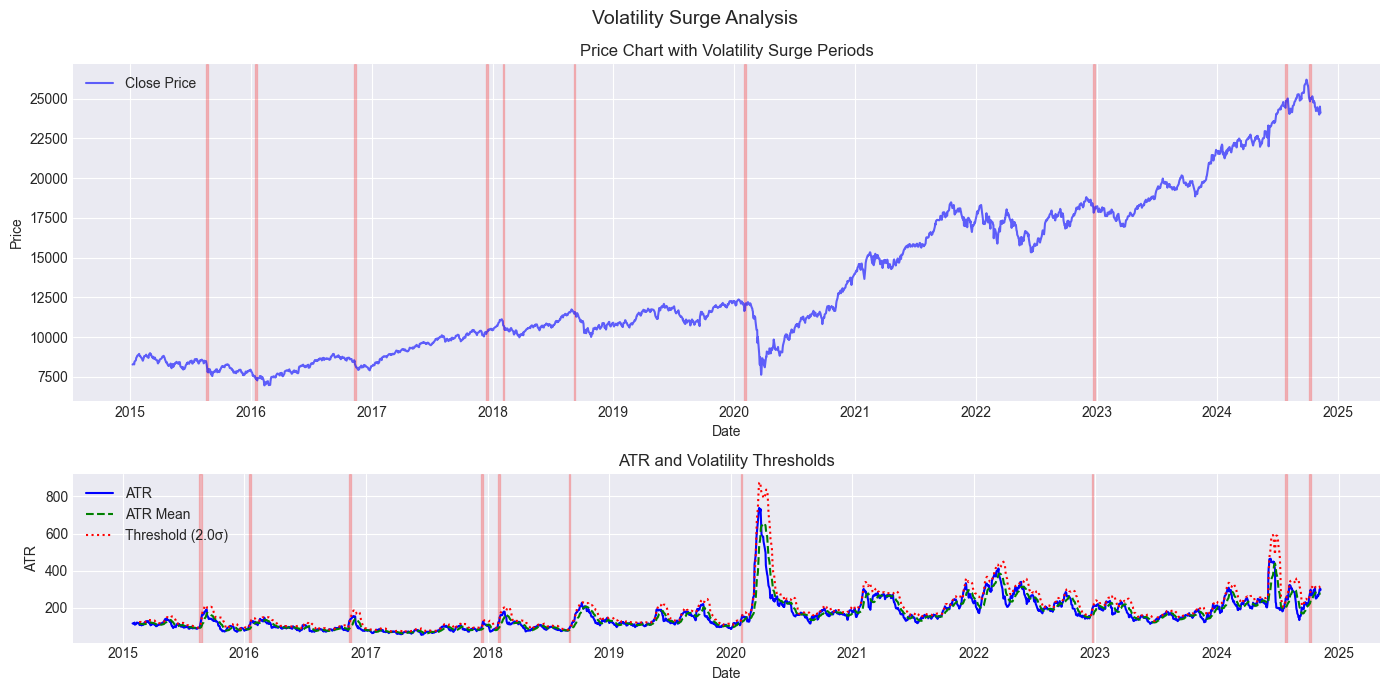

In [24]:
analyzer = VolatilitySurgeAnalyzer(daily_df)

params = {
    'window': 14,
    'std_threshold': 2.0,
    'min_duration': 4,   
    'merge_gap': 2       
}

surge_periods = analyzer.identify_volatility_surges(**params)
print(analyzer.get_surge_summary(surge_periods))
fig = analyzer.plot_volatility_analysis(**params)

### Analysis of surges in volatility

**Period 1 (2015-08-18 to 2015-08-26)**
- **Event**: The Chinese stock market crash and global economic concerns caused a massive sell-off in global equities, including NIFTY50.
- **Price Impact**: Significant **decline** in price.

---

**Period 2 (2016-01-14 to 2016-01-20)**
- **Event**: Concerns over a global slowdown, particularly in China, combined with oil price collapse.
- **Price Impact**: Notable **decline** in price.

---

**Period 3 (2016-11-09 to 2016-11-15)**
- **Event**: **Demonetization in India** and the unexpected outcome of the U.S. presidential election (Donald Trump's victory) caused market uncertainty.
- **Price Impact**: Initial **decline** in price due to shock.

---

**Period 4 (2017-12-13 to 2017-12-19)**
- **Event**: Uncertainty around the **Gujarat Assembly elections** in India and anticipation of U.S. Federal Reserve rate hikes.
- **Price Impact**: Temporary **decline** in price.

---

**Period 5 (2018-02-01 to 2018-02-06)**
- **Event**: **Union Budget 2018** introduced Long-Term Capital Gains (LTCG) tax on equity investments. Global markets also corrected sharply during this period.
- **Price Impact**: Sharp **decline** in price.

---

**Period 6 (2018-09-03 to 2018-09-06)**
- **Event**: Liquidity concerns triggered by the **IL&FS default crisis**, leading to panic in financial stocks.
- **Price Impact**: Noticeable **decline** in price.

---

**Period 7 (2020-02-01 to 2020-02-05)**
- **Event**: **Union Budget 2020** and growing concerns about the **COVID-19 outbreak** started affecting markets.
- **Price Impact**: Slight **decline**, precursor to the March 2020 crash.

---

**Period 8 (2022-12-21 to 2022-12-26)**
- **Event**: Reports of rising **COVID-19 cases in China** and concerns over global economic slowdown.
- **Price Impact**: Temporary **decline** in price.

---

**Period 9 (2024-07-23 to 2024-07-29)**  
- **Event**: Finance Minister's announcement of increased capital gains tax and Securities Transaction Tax (STT) on Futures and Options (F&O) trading. 
- **Price Impact**: Temporary **decline** in price due to market jitters and policy uncertainty.  

---

**Period 10 (2024-10-04 to 2024-10-09)**  
- **Event**: The NIFTY 50 experienced a sharp decline, attributed to global economic concerns, profit booking, and Foreign Portfolio Investor (FPI) selling. 
- **Price Impact**: Temporary **decline** in price due to risk-off sentiment, profit-taking, and FPI outflows.  

## Approach 2: Using the top 10 percentile of ATR to find periods of high volatility
- Apart from the above identified periods, we also observe from the ATR graph that there are periods of continued high volatility
- So we use the top 10 percentile of ATR to determine periods of high volatility
- We also merge periods if they are close to each other

In [25]:
class ATRAnalyzer:
    def __init__(self, data):
        self.data = data.copy()
        self.data.set_index('datetime', inplace=True)
    
    def calculate_atr(self, window):
        self.data['atr'] = self.data['tr'].rolling(window).mean()

    def identify_high_volatility_periods(self, window, percentile_threshold, min_duration, merge_gap):
        self.calculate_atr(window)
        atr = self.data['atr']
        
        threshold = np.percentile(atr.dropna(), percentile_threshold)
        high_vol_points = atr > threshold
        
        periods = []
        start_idx = None
        
        for i in range(len(high_vol_points)):
            if high_vol_points.iloc[i] and start_idx is None:
                start_idx = i
            elif (not high_vol_points.iloc[i] or i == len(high_vol_points)-1) and start_idx is not None:
                if i - start_idx >= min_duration:
                    periods.append({
                        'start_date': atr.index[start_idx].strftime('%Y-%m-%d'),
                        'end_date': atr.index[i-1].strftime('%Y-%m-%d'),
                        'duration': i - start_idx,
                    })
                start_idx = None
        
        if len(periods) == 0: return pd.DataFrame(), threshold

        merged = []
        current = periods[0]
        
        for i in range(1, len(periods)):
            days_between = (pd.to_datetime(periods[i]['start_date']) - pd.to_datetime(current['end_date'])).days - 1
            
            if days_between <= merge_gap:
                current['end_date'] = periods[i]['end_date']
                current['duration'] += periods[i]['duration'] + days_between
            else:
                merged.append(current)
                current = periods[i]
        
        merged.append(current)
        periods_df = pd.DataFrame(merged)
            
        return periods_df, threshold

    def plot_volatility_periods(self, window, percentile_threshold, min_duration, merge_gap):
        periods_df, threshold = self.identify_high_volatility_periods(window, percentile_threshold, min_duration, merge_gap)
        atr = self.data['atr']
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), height_ratios=[2, 1])
        fig.suptitle(f'High Volatility Periods', fontsize=14)
        
        ax1.plot(self.data.index, self.data['close'], color='blue', alpha=0.6, label='Close Price')
        
        for _, period in periods_df.iterrows():
            start = pd.to_datetime(period['start_date'])
            end = pd.to_datetime(period['end_date'])
            ax1.axvspan(start, end, color='red', alpha=0.2)
        
        ax1.set_title('Price Chart with High Volatility Periods')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price')
        ax1.legend()
        
        ax2.plot(atr.index, atr, label='ATR', color='blue')
        ax2.axhline(y=threshold, color='r', linestyle='--', label=f'{percentile_threshold}th Percentile')
        
        for _, period in periods_df.iterrows():
            start = pd.to_datetime(period['start_date'])
            end = pd.to_datetime(period['end_date'])
            ax2.axvspan(start, end, color='red', alpha=0.2)
        
        ax2.set_title('ATR with Threshold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('ATR')
        ax2.legend()
        
        fig.tight_layout()
        return fig

    def get_period_summary(self, periods_df, percentile):
        if len(periods_df) == 0:
            return "No high volatility periods detected."
            
        summary = f"High Volatility Periods (Top {100-percentile}%):\n\n"
        
        for i, period in periods_df.iterrows():
            summary += f"Period {i+1}:"
            summary += f" Duration: {period['start_date']} to {period['end_date']} "
            summary += f"({period['duration']} days)\n"
            
        return summary

High Volatility Periods (Top 10%):

Period 1: Duration: 2020-03-11 to 2020-04-28 (31 days)
Period 2: Duration: 2021-02-01 to 2021-02-15 (11 days)
Period 3: Duration: 2021-03-04 to 2021-03-19 (11 days)
Period 4: Duration: 2021-03-30 to 2021-04-08 (7 days)
Period 5: Duration: 2021-04-19 to 2021-04-26 (5 days)
Period 6: Duration: 2021-11-29 to 2021-12-15 (13 days)
Period 7: Duration: 2022-01-27 to 2022-03-30 (43 days)
Period 8: Duration: 2022-04-28 to 2022-06-03 (26 days)
Period 9: Duration: 2022-06-21 to 2022-06-29 (7 days)
Period 10: Duration: 2022-09-30 to 2022-10-14 (10 days)
Period 11: Duration: 2024-01-25 to 2024-02-15 (15 days)
Period 12: Duration: 2024-06-04 to 2024-06-25 (15 days)
Period 13: Duration: 2024-08-05 to 2024-08-23 (14 days)
Period 14: Duration: 2024-10-07 to 2024-10-23 (13 days)
Period 15: Duration: 2024-10-30 to 2024-11-07 (7 days)



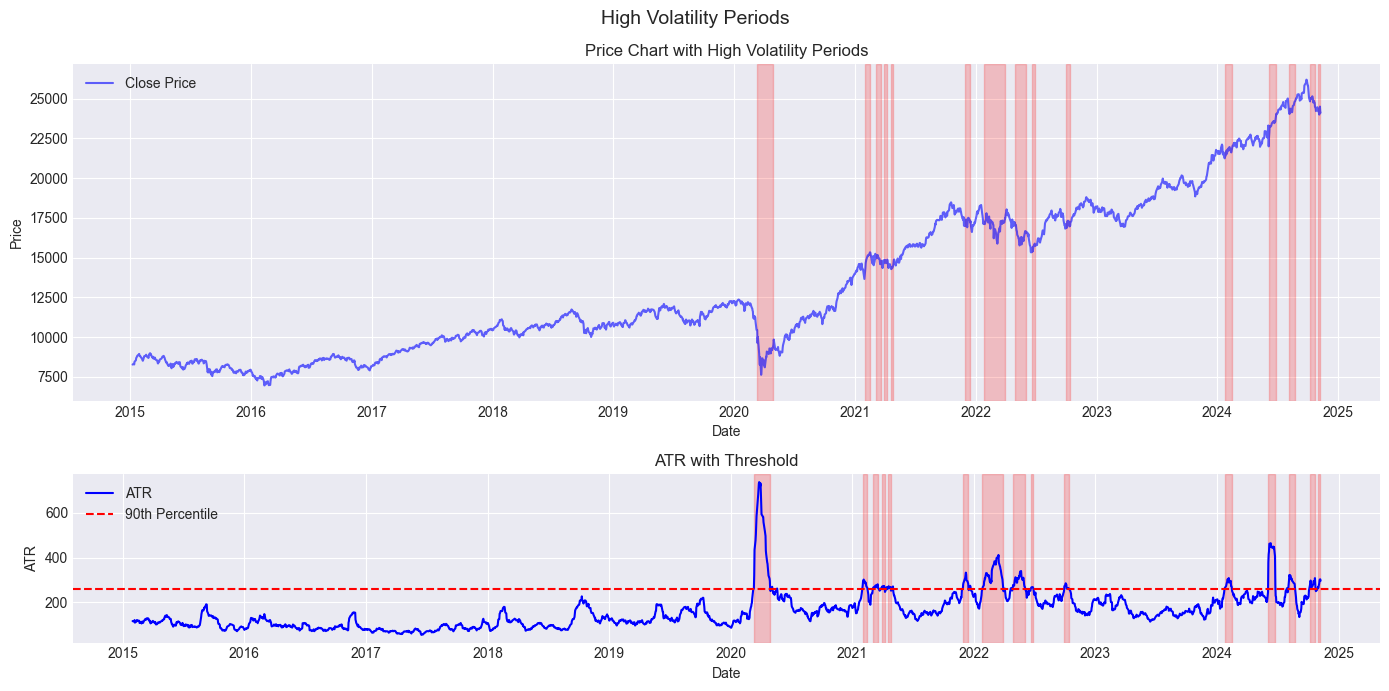

In [26]:
analyzer = ATRAnalyzer(daily_df)

params = {
    'window': 14,           
    'percentile_threshold': 90,
    'min_duration': 5,      
    'merge_gap': 3          
}

high_vol_periods, threshold = analyzer.identify_high_volatility_periods(**params)
print(analyzer.get_period_summary(high_vol_periods, params['percentile_threshold']))
fig = analyzer.plot_volatility_periods(**params)

### Analysis of periods of high volatility

**Period 1 (2020-03-11 to 2020-04-28 - 31 days)**  
- **Event**: The **COVID-19 pandemic** triggered global lockdowns and market panic.  
- **Impact**: Significant **price decline** during this period, reflecting the initial shock to global markets.

---

**Period 2 (2021-02-01 to 2021-02-15 - 11 days)**  
- **Event**: Post-**Union Budget 2021**, the market reacted positively to the government's spending plans.  
- **Impact**: Sharp **price rise**, indicating optimism among investors.

---

**Period 3 (2021-03-04 to 2021-03-19 - 11 days)**  
- **Event**: Rising **bond yields** and inflation fears in global markets created uncertainty.  
- **Impact**: **Price decline**, driven by cautious sentiment.

---

**Period 4 (2021-03-30 to 2021-04-08 - 7 days)**  
- **Event**: Concerns about the second wave of **COVID-19** in India.  
- **Impact**: Minor **price decline** due to increasing health and economic risks.

---

**Period 5 (2021-04-19 to 2021-04-26 - 5 days)**  
- **Event**: The **second wave of COVID-19** intensified, impacting investor confidence.  
- **Impact**: Continued **price decline** as cases surged.

---

**Period 6 (2021-11-29 to 2021-12-15 - 13 days)**  
- **Event**: Fears of the **Omicron variant** and expectations of tighter monetary policies globally.  
- **Impact**: Moderate **price decline**, reflecting cautious market behavior.

---

**Period 7 (2022-01-27 to 2022-03-30 - 43 days)**  
- **Event**: The **Russia-Ukraine conflict** caused significant global instability.  
- **Impact**: Notable **price decline** at the onset, followed by partial recovery as markets adjusted.

---

**Period 8 (2022-04-28 to 2022-06-03 - 26 days)**  
- **Event**: U.S. Federal Reserve **interest rate hikes** and inflation concerns.  
- **Impact**: Steady **price decline**, driven by tightening monetary policy.

---

**Period 9 (2022-06-21 to 2022-06-29)**  
- **Event**: The market declined due to global risk-off sentiment and heavy Foreign Portfolio Investor (FPI) outflows.  
- **Price Impact**: Temporary **decline** in price as investors exited riskier assets amid global uncertainties.  

---

**Period 10 (2022-09-30 to 2022-10-14 - 10 days)**  
- **Event**: Quarterly earnings season and continued global inflation concerns.  
- **Impact**: Moderate **price decline**, likely influenced by mixed corporate results.

---

**Period 11 (2024-01-25 to 2024-02-15)**  
- **Event**: Weak corporate earnings, persistent foreign outflows, and economic uncertainties.  
- **Price Impact**: Prolonged **decline** in price as investor confidence weakened over earnings disappointments and macroeconomic concerns.  

---

**Period 12 (2024-06-04 to 2024-06-25)**  
- **Event**: Market dropped sharply following Lok Sabha election results that did not meet exit poll predictions, causing investor disappointment.  
- **Price Impact**: Temporary **decline** in price due to political uncertainties and nervous market sentiment.  

---

**Period 13 (2024-08-05 to 2024-08-23)**  
- **Event**: Renewed political concerns post-Lok Sabha elections created uncertainty, leading to a sharp decline in NIFTY 50.  
- **Price Impact**: Temporary **decline** in price as investors reacted to the unstable political climate.  

---

**Period 14 (2024-10-07 to 2024-10-23)**  
- **Event**: Escalating geopolitical tensions, particularly the Israel-Iran conflict, triggered risk aversion in the markets.  
- **Price Impact**: Temporary **decline** in price as investors shifted away from equities amid rising global instability.  

---

**Period 15 (2024-10-30 to 2024-11-07)**  
- **Event**: Weak corporate earnings, foreign investor withdrawals, and broader economic concerns weighed on market sentiment.  
- **Price Impact**: Temporary **decline** in price as selling pressure increased due to deteriorating economic indicators.

## Verifying high volatility periods using GARCH(1,1) model

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from arch import arch_model

class VolatilityAnalyzer:
    def __init__(self, df):
        self.df = df.copy()
        self.df.set_index('datetime', inplace=True)
        
        self.df['returns'] = np.log(self.df['close']).diff()
        self.df['returns'] = self.df['returns'].bfill()  # Backfill first NaN
        
    def fit_garch(self, p=1, q=1):
        model = arch_model(self.df['returns'], p=p, q=q, rescale=True)
        self.garch_model = model.fit(disp='off')
        self.df['conditional_volatility'] = self.garch_model.conditional_volatility
        self.df['conditional_volatility'] = self.df['conditional_volatility'].bfill().ffill()
        
    def cluster_volatility(self, n_clusters):
        features = pd.DataFrame({'conditional_volatility': self.df['conditional_volatility'],'range_volatility': self.df['tr']})
        
        features = features.bfill().ffill()
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.df['volatility_cluster'] = kmeans.fit_predict(scaled_features)
        
    def plot_volatility_clusters(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.df.index, self.df['close'], color='black', label='Close Price', alpha=0.5)
        
        for cluster in self.df['volatility_cluster'].unique():
            mask = self.df['volatility_cluster'] == cluster
            plt.scatter(self.df[mask].index, self.df[mask]['close'], label=f'Cluster {cluster}', alpha=0.6)
            
        plt.title('Price Movement with Volatility Clusters')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

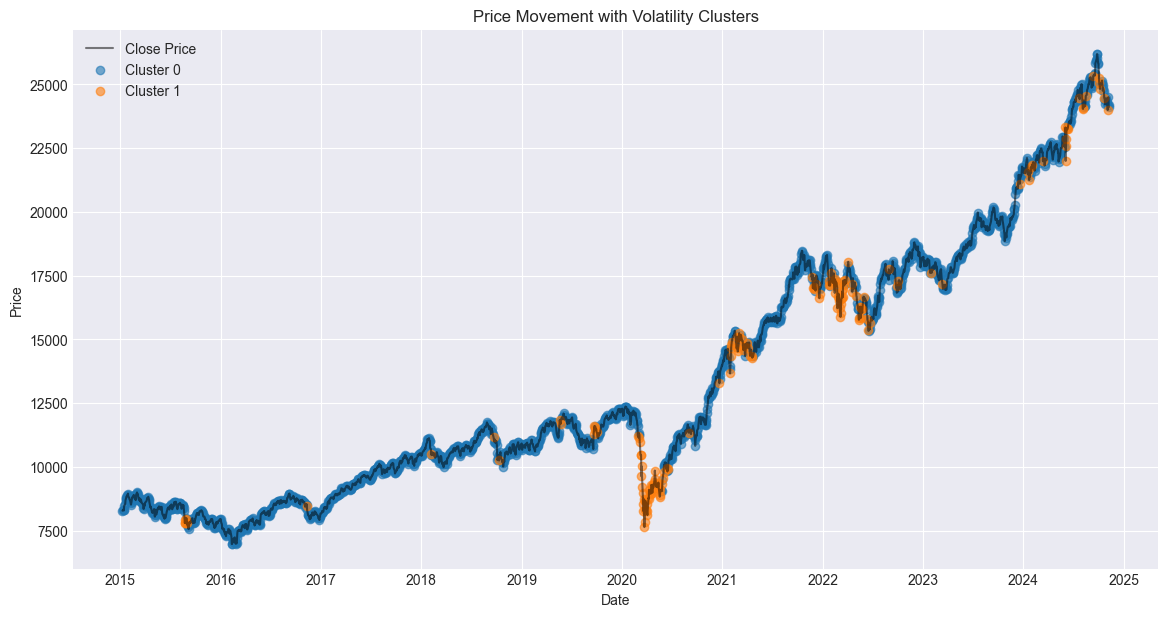

In [28]:
vol_analyzer = VolatilityAnalyzer(daily_df)
vol_analyzer.fit_garch()
vol_analyzer.cluster_volatility(2)
vol_analyzer.plot_volatility_clusters()

#### We observe that the volatility periods obtained from ATR analysis are also highlighted by the GARCH(1,1) model

## Actionable Insights
1. We observe that major political and economic events in other prominent nations in the world indirectly influence the Indian market.
2. Whenever tax restrictions are imposed on trading, we observe an immediate decline in the price.
3. Elections influence the market, and the outcome of the election dictates whether the market prices will rise or fall.
4. Budget allocations also influence the market prices, where prices change depending the decisions made by the Government.
5. The COVID-19 pandemic witnessed the largest fall in price of NIFTY 50 over the given time period, with subsequent waves also causing decline in prices.

We can exploit such events. For example, if the prices are predicted to go up, we could use bullish spreads (using options) to exploit the rise in prices.

## Risk Management during volatile periods
1. We can use ATR and its moving average to monitor spikes in volatility. 
2. When ATR rises above the threshold of SMA + 2 * std dev., we should take smaller positions in the market, as we are exposed to higher volatility.
3. We first determine whether the trend is bullish or bearish. Then we can place limit order at slightly lower price for buying or slightly higher price for selling.
5. The limits for stop-loss should be proportional to the ATR and based on the current price. This ensures that we lock in profits when the trend reverses.
6. Prices eventually rise up some time after the decline. So if we observe a temporary decline, we could use call options or futures to secure lower future prices.
